Solving the mean field $\alpha - \Omega $ dynamo equation in the kinematic region:
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right]-\eta \frac{\partial^2 \bar{B}_r}{\partial z^2} -\frac{\partial \alpha \bar{B}_\phi}{\partial z}, \\
& \frac{\partial \bar{B}_\phi}{\partial t}=\eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] -\eta \frac{\partial^2 \bar{B}_\phi}{\partial z^2} -q\Omega \bar{B}_r\\
\end{aligned}
\end{aligned}
$$

Using no-z approximtion and expressing $q\Omega$ in terms of Dynamo number. Take $\eta \sim \eta_t$ We get the equations as follows:
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \eta \frac{\pi^2}{4h^2} \bar{B}_r - \frac{2}{\pi h}\alpha \bar{B}_\phi, \\
& \frac{\partial \bar{B}_\phi}{\partial t}=\eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] -\eta \frac{\pi^2}{4h^2}\bar{B_\phi} -q\Omega \bar{B}_r\\
\end{aligned}
\end{aligned}
$$

Now making the same equations dimensionless, we get:
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \frac{\pi^2 \bar{B}_r}{4} - \frac{2}{\pi}\alpha \bar{B}_\phi, \\
& \frac{\partial \bar{B}_\phi}{\partial t}=\left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2}{4}\bar{B_\phi} + r\frac{d\Omega}{dr}  \bar{B}_r\\
\end{aligned}
\end{aligned}
$$

Putting $h_0=R_0$, we get:
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \frac{\pi^2 \bar{B}_r}{4} - \frac{2}{\pi}\alpha \bar{B}_\phi, \\
& \frac{\partial \bar{B}_\phi}{\partial t}= \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2}{4}\bar{B_\phi} + r\frac{d\Omega}{dr}  \bar{B}_r\\
\end{aligned}
\end{aligned}
$$


#### Some Definations

In [14]:
# Librarires
import numpy as np
import matplotlib.pyplot as plt

#Define Constants
omega_0 = 150
h0= 0.5 #kpc

#Define radial grid parameters
r_min = 0.01   # Minimum radial coordinate
r_max = 10.0   # Maximum radial coordinate
Nr = 100      # Number of grid points
r_values = np.linspace(r_min, r_max, Nr) # Create radial grid
dr= (r_max - r_min)/Nr

#Define Time parameters
t_min = 0
t_max = 3
Nt = 10000 
t_values= np.linspace(t_min,t_max,Nt)
dt = (t_max - t_min)/Nt

# Define the number of ghost zones
num_ghost_zones = 5

#extend the grid
r_min_new= r_min- num_ghost_zones*dr
r_max_new =  r_max + num_ghost_zones*dr

Nr_new= Nr+ 2*num_ghost_zones+1
r_values= np.linspace(r_min_new,r_max_new,Nr_new)
Nr=Nr_new

#Define spatial dependence of Ω and α.
omega = omega_0 / (1+(r_values/2)**2)**0.5

In [15]:
def DynamoNumber(alpha_0):
    q = -(r_values/omega) * np.gradient(omega, r_values)
    D = - alpha_0 * q * omega * h0**3
    return np.mean(D)

#### Plot the initial magnetic fields

In [16]:
#Define initial see magnetic field
Br_Orig = np.sin(np.pi*(r_min-r_values)/(r_max-r_min))
Bphi_Orig = (-1)*np.sin(np.pi*(r_min-r_values)/(r_max-r_min))

#### Coupled Equations to be Solved

In [17]:
#Define coupled equations
def coupled(B_r,B_phi,alpha):
    dBr_dt= np.gradient(1/r_values * np.gradient(r_values * B_r,dr),dr) - (np.pi**2 *B_r)/(4) - (2/np.pi)*alpha*B_phi
    dBphi_dt= np.gradient(1/r_values * np.gradient(r_values * B_phi,dr),dr) - (np.pi**2 *B_phi)/(4) + (r_values * np.gradient(omega,dr)*B_r)
    return np.array([dBr_dt,dBphi_dt])

#### RK4 Method

In [18]:
def rk4_step(B__r,B__phi,alpha):
    k1 = dt * coupled(B__r, B__phi,alpha)
    k2 = dt * coupled(B__r + 0.5 * k1[0], B__phi + k1[1] * 0.5,alpha)
    k3 = dt * coupled(B__r + 0.5 * k2[0], B__phi + k2[1] * 0.5,alpha)
    k4 = dt * coupled(B__r + k3[0], B__phi + k3[1],alpha)

    X = B__r + (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) / 6
    Y = B__phi + (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6
    
    for iter in range(num_ghost_zones):
        X[5-i]=-X[5+i]
        Y[5-i]=-Y[5+i]
        X[-6+i]=-X[-6-i]
        Y[-6+i]=-Y[-6-i]
    
    #Define BCs
    X[5]=0
    X[-6]=0
    Y[-6]=0
    Y[5]=0
    
    return X,Y

#### Plotting the Initial Magnetic fields

In [19]:
def InitialPlot():
    print('Initial Seed Magetic field')
    # Plot Br
    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 1)
    plt.plot(r_values, Br_Orig, color='blue')
    plt.title('Br vs r_values')
    plt.xlabel('radius')
    plt.ylabel('Br')
    plt.xlim(r_min,r_max) #Cropping the plot to physical realm only
    plt.grid(True)

    #Plot Bphi
    plt.subplot(1, 2, 2)
    plt.plot(r_values, Bphi_Orig, color='red')
    plt.title('Bphi vs r_values')
    plt.xlabel('radius')
    plt.ylabel('Bphi')
    plt.xlim(r_min,r_max) #Cropping the plot to physical realm only
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### Plotting the evolution of $B_\phi$ & $B_r$ at time steps for a given spatial point.

In [20]:
def MagVsradial(Br_Evolution,Bphi_Evolution,alpha):        
    # Plot the spatial solution for Br
    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 1)
    for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
        plt.plot(r_values, Br_Evolution[t, :], label=f'Time = {t * dt:.2f} Myr')
    plt.xlabel('Radial Distance (R)')
    plt.ylabel(r'$B_r$')
    plt.title(r'Spatial Solution for $B_r$ at Different Time Steps')
    plt.legend()
    plt.xlim(r_min,r_max) #Cropping the plot to physical realm only
    plt.tight_layout()
    

    # Plot the spatial solution for Bphi
    plt.subplot(1, 2, 2)
    for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
        plt.plot(r_values, Bphi_Evolution[t, :], label=f'Time = {t * dt:.2f} Myr')
    plt.xlabel('Radial Distance (R)')
    plt.ylabel(r'$B_\phi$')
    plt.title(r'Spatial Solution for $B_\phi$ at Different Time Steps')
    plt.legend()
    plt.xlim(r_min,r_max) #Cropping the plot to physical realm only
    plt.tight_layout()
    plt.show()

#### Plotting $Log_{10} \left(\sqrt{B_r^2 + B_\phi^2}\right)$ Vs Time)

In [21]:
# Seems slightly complicated but let's get on with it
def LogB_T(Br_Evolution,Bphi_Evolution):
    result=[]
    for i in range(len(Br_Evolution)):
        test = 0
        for j in range(len(Br_Evolution[0])):
            test = test + (Br_Evolution[i][j]**2 + Bphi_Evolution[i][j]**2)**0.5
        result.append(test/len(Br_Evolution[0]))

    plt.figure(figsize=(12, 6))
    plt.plot(np.linspace(0, t_max, Nt + 1),np.log10(np.abs(result)))
    plt.xlabel('Time')
    plt.ylabel(r'$\log_{10}(B)$')
    plt.title(r'$Log_{10} \left(\sqrt{B_r^2 + B_\phi^2}\right)$ Vs Time')
    plt.legend([f'r={r_values[i]:.2f}' for i in range(0, Nr, Nr//10)])
    plt.tight_layout()
    plt.show()

#### Finding the Global Gamma

For different values of alpha, the slope of the tail of Log(B) Vs time plot is taken. 
Whenever the slope changes sign from negative to positive. 
The corresponding two alpha values is used to calculate the average alpha, which is further used to find the critical Dynamo Number.

In [22]:
def Gamma(alpha):
    Store=[]
    for i in alpha:
        Br_t = np.zeros((Nt + 1, Nr))
        Bphi_t = np.zeros((Nt + 1, Nr))
        Br=Br_Orig
        Bphi=Bphi_Orig
        for t in range(Nt + 1):
            Br_t[t, :] = np.copy(Br)
            Bphi_t[t, :] = np.copy(Bphi)
            Br,Bphi= rk4_step(Br,Bphi,i)
        
        result=[]
        for i in range(len(Br_t)):
            test = 0
            for j in range(len(Br_t[0])):
                test = test + (Br_t[i][j]**2 + Bphi_t[i][j]**2)**0.5
            result.append(test/len(Br_t[0]))
        
        slope, intercept = np.polyfit(t_values[-20:], result[-20:], 1)
        Store.append(slope)
        if(Store[-1]>0 and Store[-2]<0):
            return (alpha[len(Store)-1]+alpha[len(Store)-2])/2

In [23]:
def Gamma_BC(alpha):
    Store=[]
    for i in alpha:
        Br_t = np.zeros((Nt + 1, Nr))
        Bphi_t = np.zeros((Nt + 1, Nr))
        Br=Br_Orig
        Bphi=Bphi_Orig
        for t in range(Nt + 1):
            Br[0]=0
            Br[-1]=0
            Bphi[0]=0
            Bphi[-1]=0
                
            Br_t[t, :] = np.copy(Br)
            Bphi_t[t, :] = np.copy(Bphi)
            Br,Bphi= rk4_step(Br,Bphi,i)
        
        result=[]
        for i in range(len(Br_t)):
            test = 0
            for j in range(len(Br_t[0])):
                test = test + (Br_t[i][j]**2 + Bphi_t[i][j]**2)**0.5
            result.append(test/len(Br_t[0]))
        
        slope, intercept = np.polyfit(t_values[-20:], result[-20:], 1)
        Store.append(slope)
        if(Store[-1]>0 and Store[-2]<0):
            return (alpha[len(Store)-1]+alpha[len(Store)-2])/2

#### Pitch Angle

In [24]:
def Pitch(Br_Evolution,Bphi_Evolution):
    # Function to compute the pitch angle
    def Pitch_angle(Br, Bphi):
        return np.arctan2(Br, Bphi)

    # Store the evolution of pitch angle at different time steps
    evolution_pitch = np.zeros((Nt + 1, Nr))

    # Time-stepping scheme using Runge-Kutta
    for t in range(Nt + 1):
        evolution_pitch[t, :] = Pitch_angle(Br_Evolution[t, :], Bphi_Evolution[t, :])

    # Plot the spatial solution for the pitch angle
    plt.figure(figsize=(20, 6))
    for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
        plt.plot(r_values, evolution_pitch[t, :], label=f'Time = {t * dt:.2f}')
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Pitch Angle (p)')
    plt.title('Spatial Solution for Pitch Angle at Different Time Steps')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Finally calling the equations to get the output

Initial Seed Magetic field


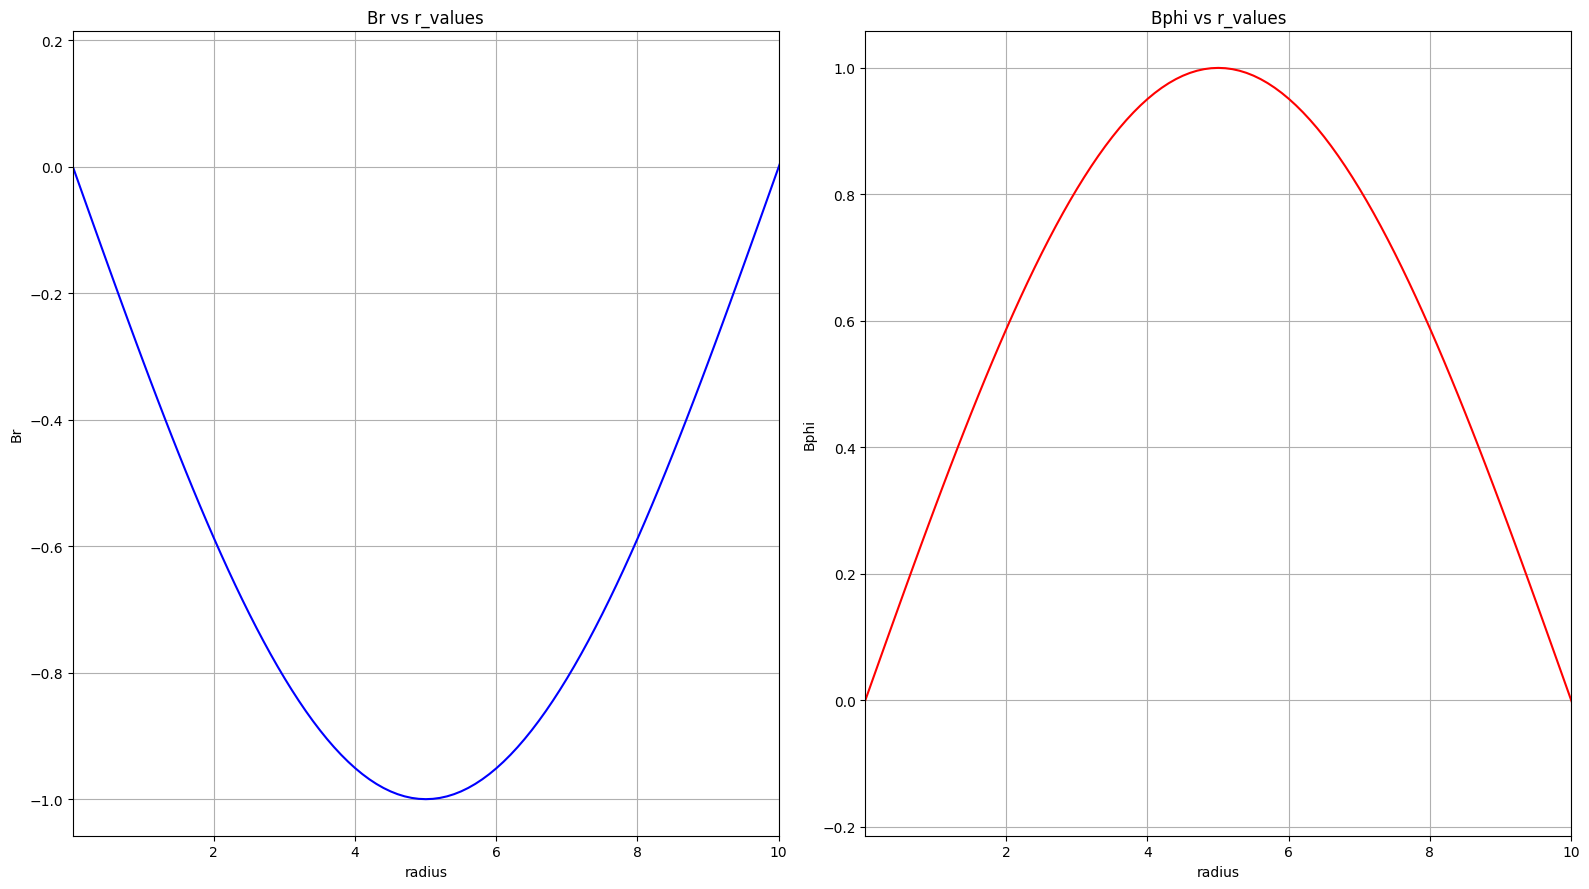

For alpha value= 1 Dynamo Number is: -4.694983291534065


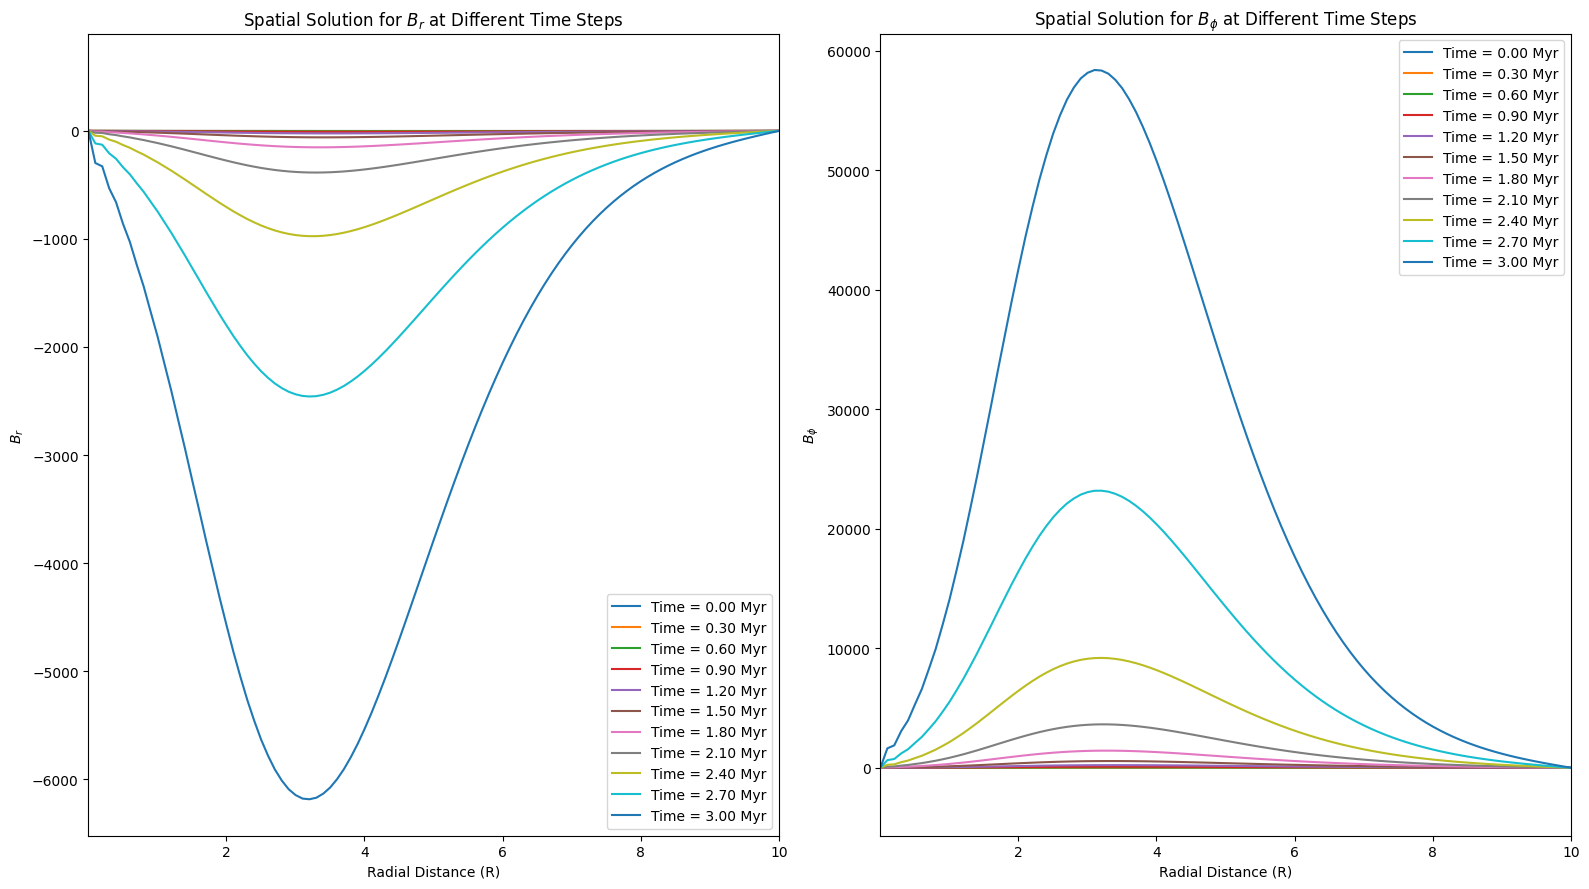

For alpha value= 2 Dynamo Number is: -9.38996658306813


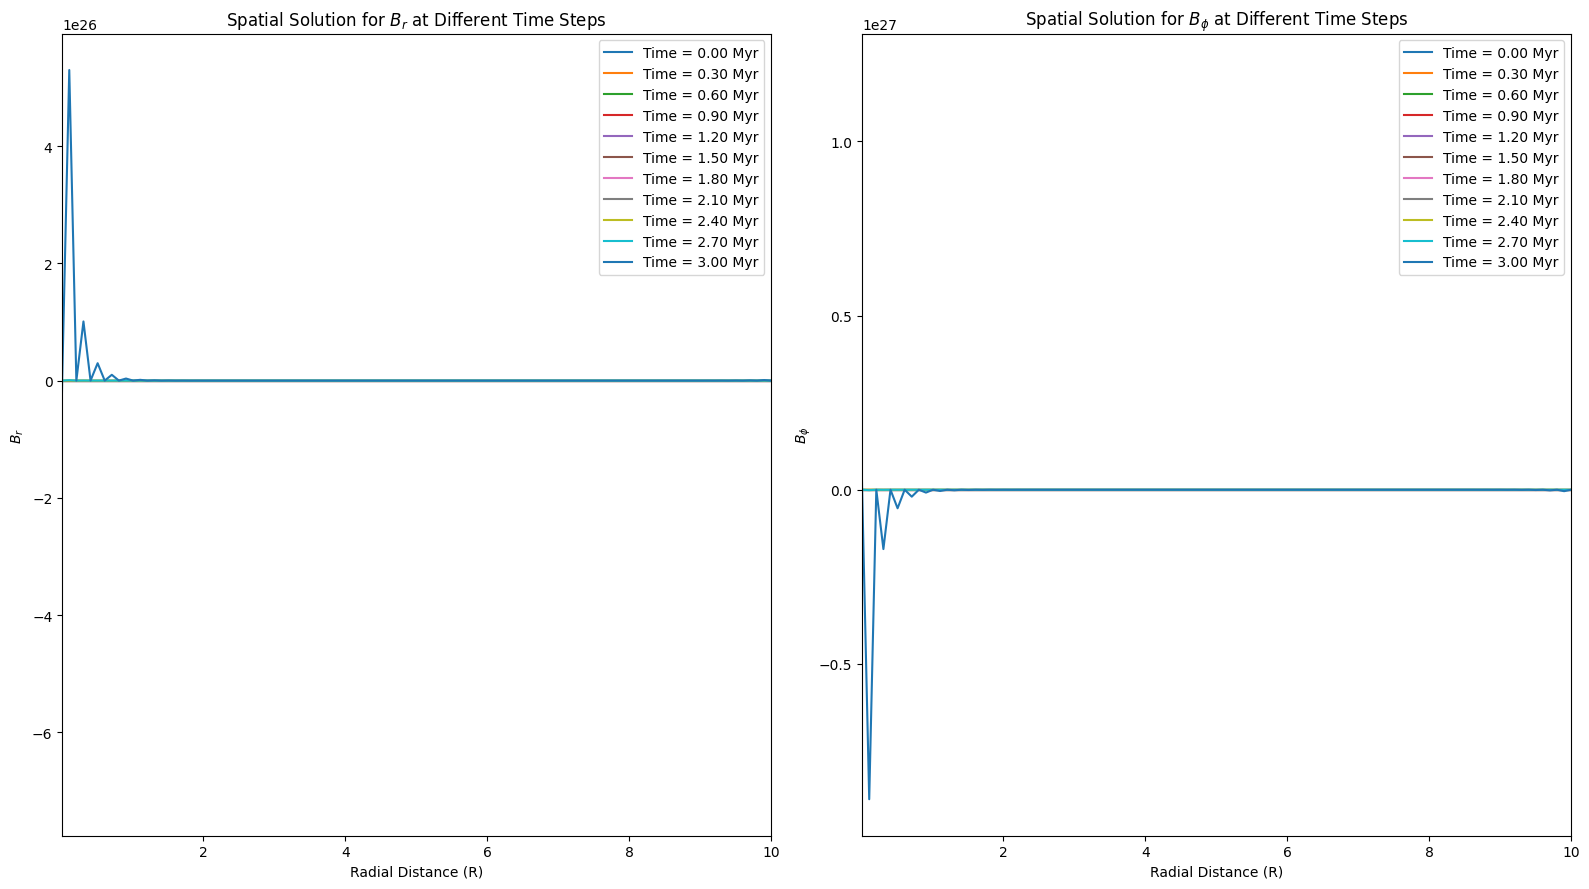

For alpha value= 3 Dynamo Number is: -14.084949874602191


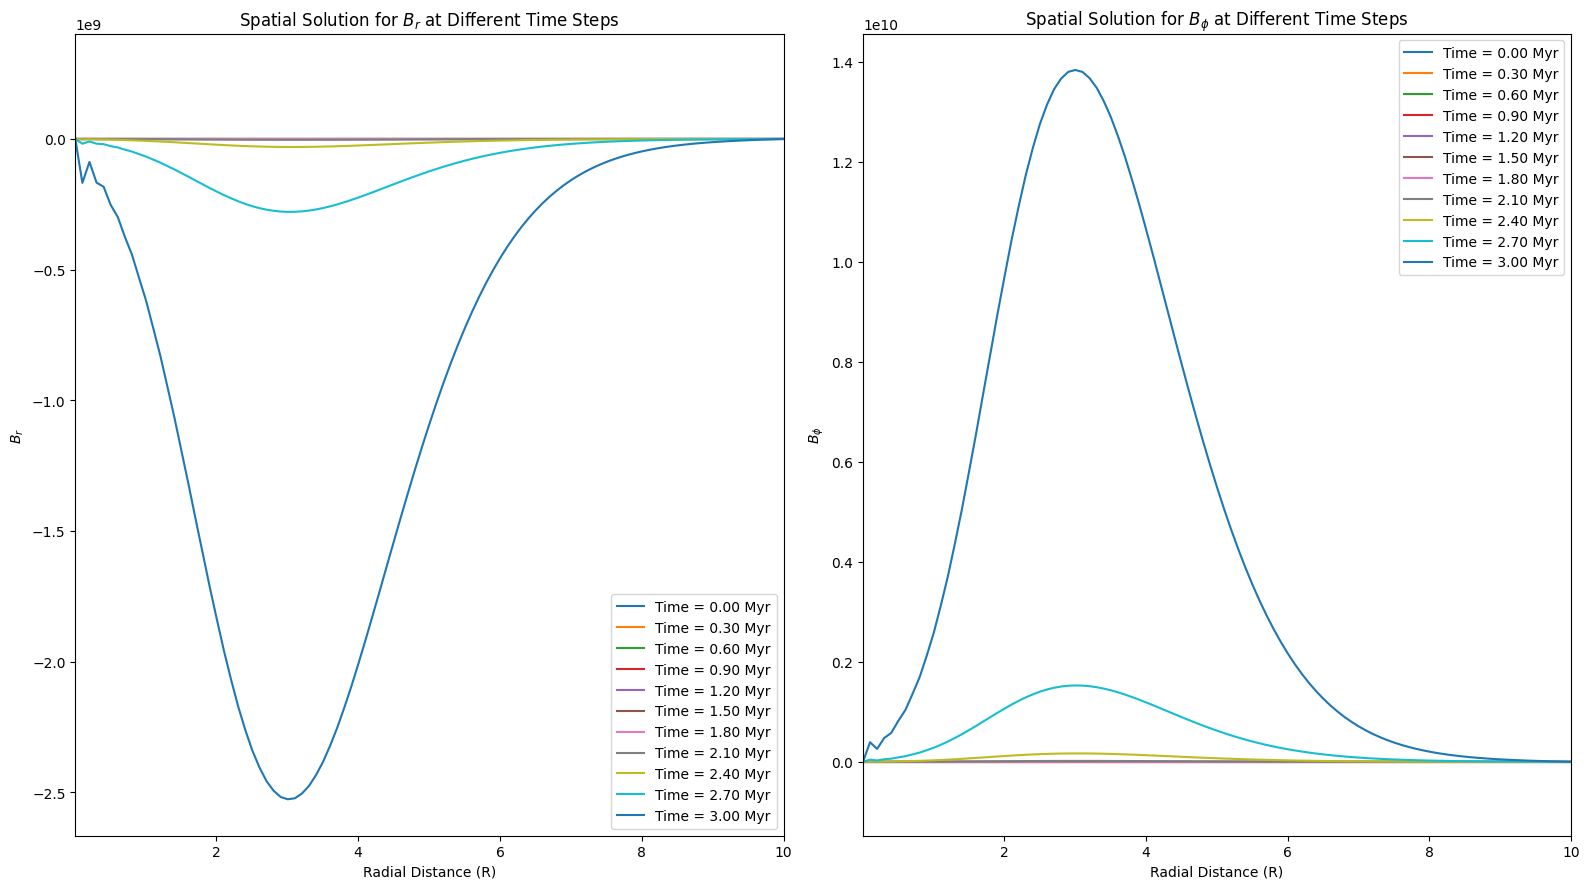

For alpha value= 4 Dynamo Number is: -18.77993316613626


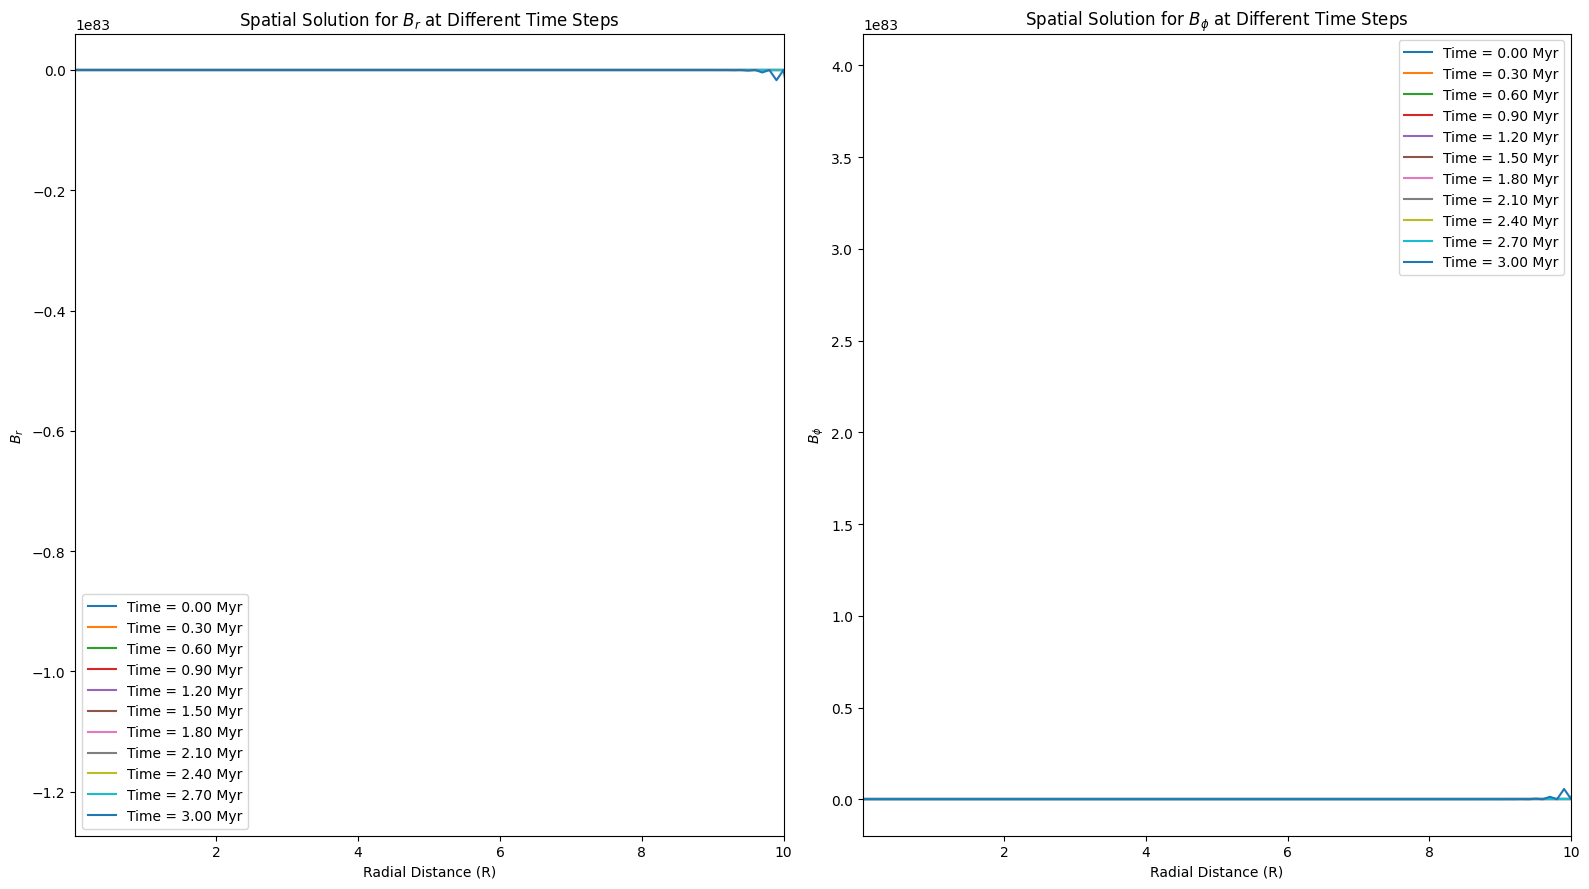

For alpha value= 5 Dynamo Number is: -23.47491645767032


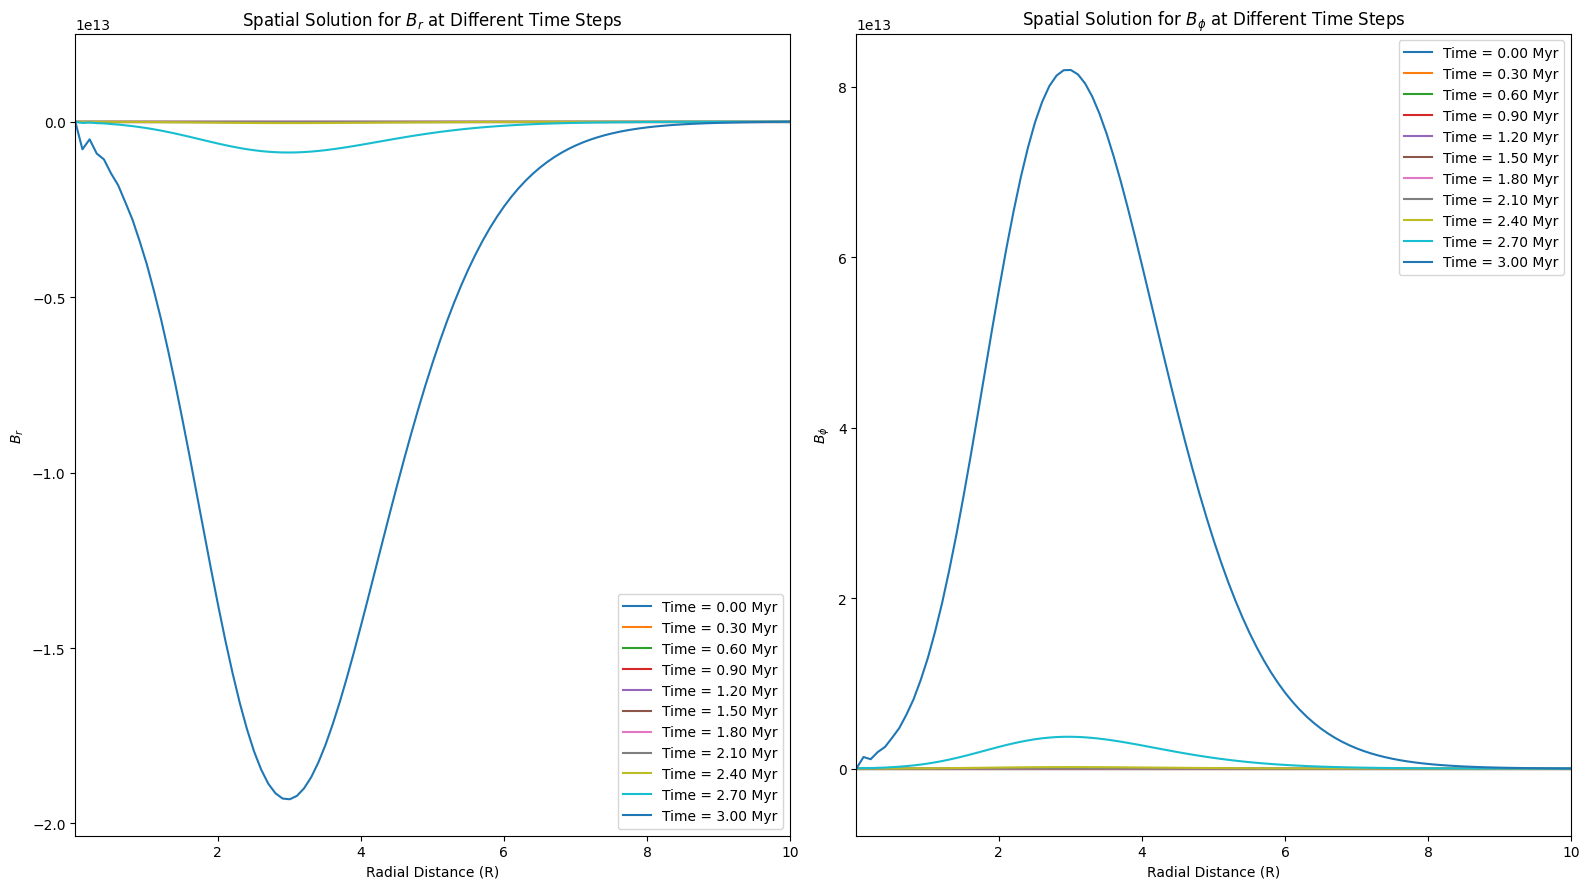

For alpha value= 6 Dynamo Number is: -28.169899749204383


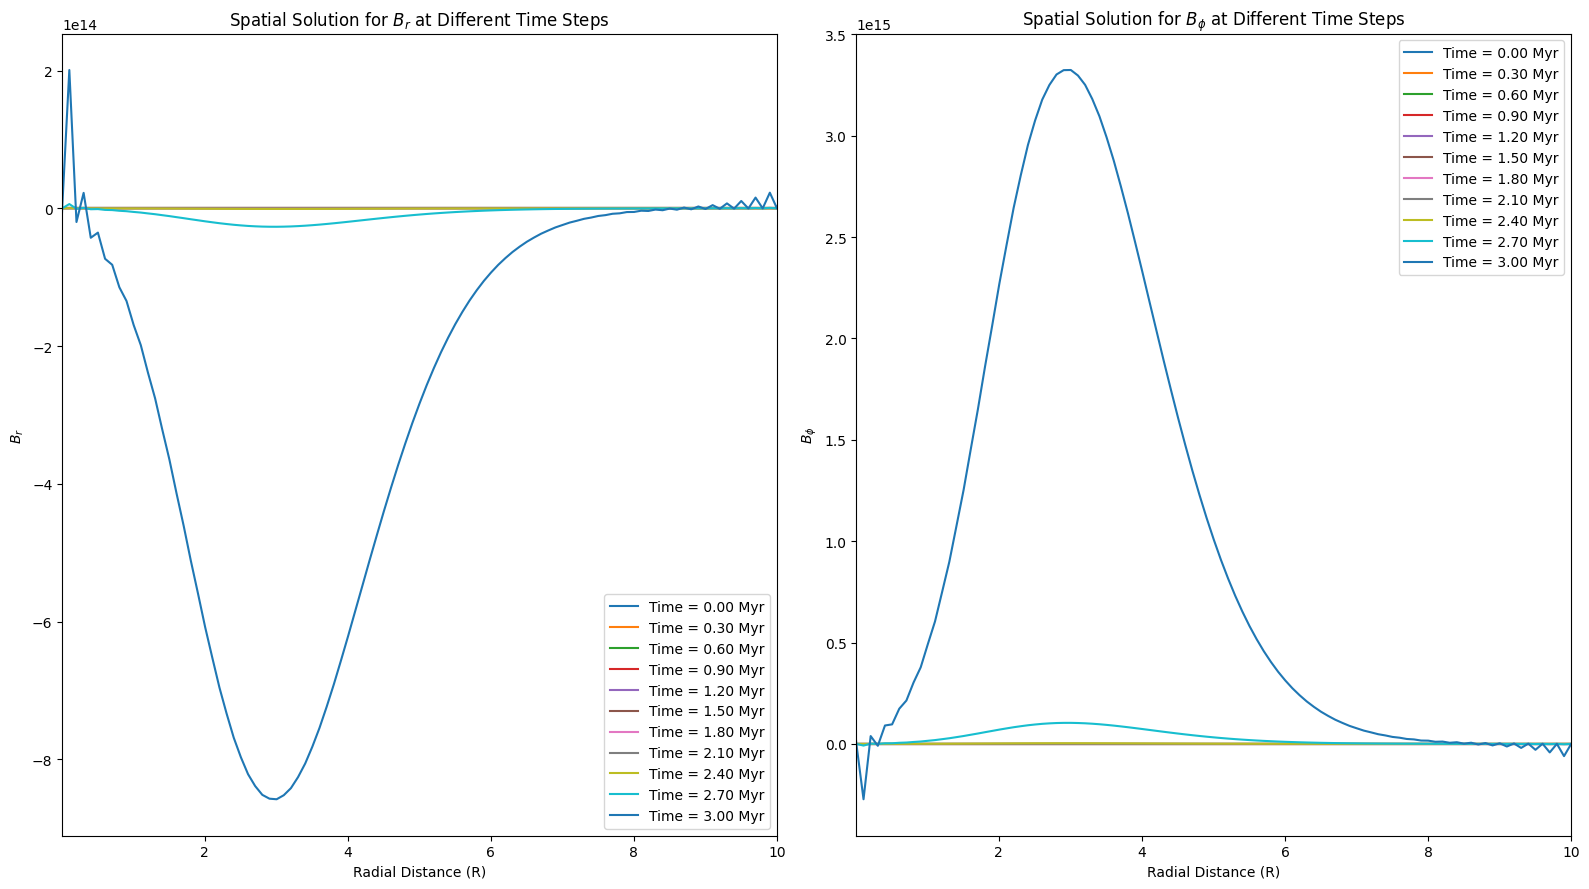

For alpha value= 7 Dynamo Number is: -32.864883040738455


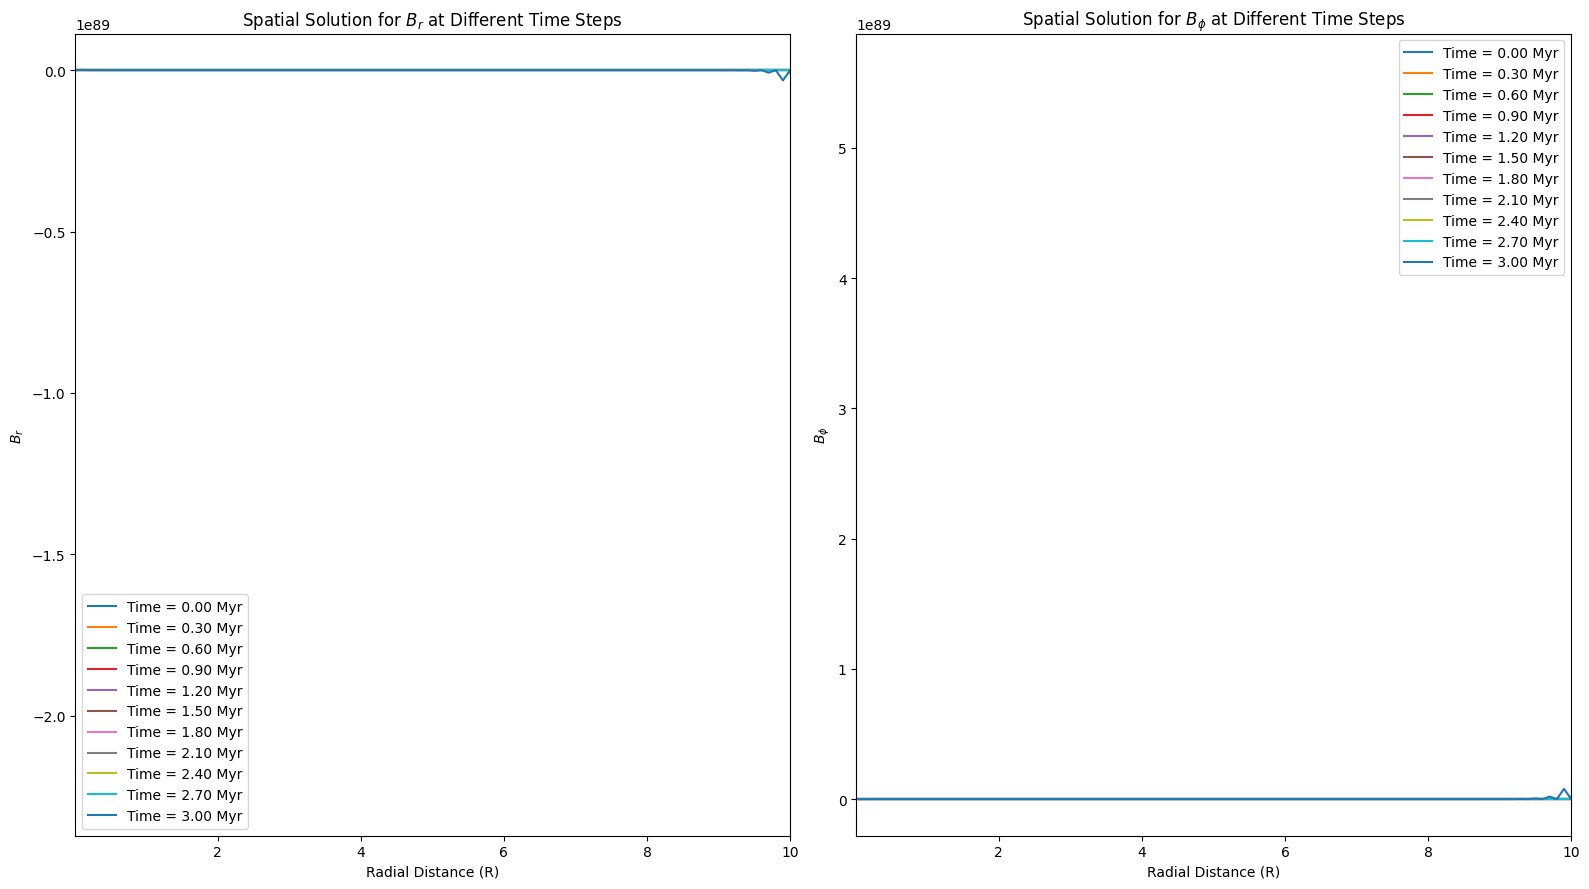

In [26]:
# Define the alpha
alpha = [a for a in range(1,8)]
# Plotting the initial magnetic fields
InitialPlot()

for i in alpha:
    print('For alpha value=',i,'Dynamo Number is:',DynamoNumber(i))
    Br_t = np.zeros((Nt + 1, Nr))
    Bphi_t = np.zeros((Nt + 1, Nr))
    Br=Br_Orig
    Bphi=Bphi_Orig
    for t in range(Nt + 1):
        Br_t[t, :] = np.copy(Br)
        Bphi_t[t, :] = np.copy(Bphi)
        Br,Bphi= rk4_step(Br,Bphi,i)

    #Plotting the evolution of Br and Bphi against time for different radial distance.
    MagVsradial(Br_t,Bphi_t,i)
    
    #Defining the pitch
    #Pitch(Br_t,Bphi_t)
    
    #Plotting Log B Vs Time to obtain the global gamma value
    #LogB_T(Br_t,Bphi_t)

#finding Dc
# Req= Gamma(np.linspace(2.5,5,10))
# print('The Crtical Dynamo number is', Req,'r * dΩ/dr$')
